In [378]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm

import theano
import theano.tensor as tt
from theano.compile.ops import as_op

from scipy.stats import nbinom
from scipy.stats import beta
from scipy.stats import uniform
from scipy.stats import geom
from scipy.stats import norm
from scipy.special import comb
from scipy.optimize import minimize

%matplotlib inline

(a)

In [210]:
#setup

m = 5
r = [x for x in range(3,8)]
q = [0.1, 0.3, 0.3, 0.2, 0.1]
H = [2, 6, 1, 2, 5, 2, 6, 5, 1, 9, 11, 6, 4, 10]
H_t = [x for x in range(1,len(H)+1)]

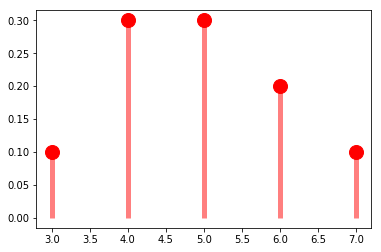

In [211]:
#prior pmf

fig, ax = plt.subplots(1, 1)
ax.plot(r, q, 'ro', ms=14, label='Prior')
ax.vlines(r, 0, q, colors='r', lw=5, alpha=0.5)

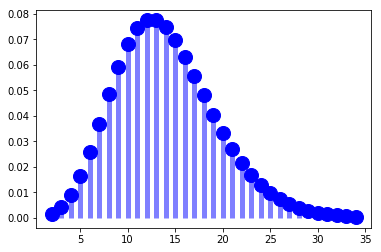

In [212]:
#likelihood: negative binomial distribution

n, p = 14, 0.5
fig, ax = plt.subplots(1, 1)

x = np.arange(nbinom.ppf(0.001, n, p), nbinom.ppf(.999, n, p))
ax.plot(x, nbinom.pmf(x, n, p), 'bo', ms=14, label='Likelihood')
ax.vlines(x, 0, nbinom.pmf(x, n, p), colors='b', lw=5, alpha=0.5)

In [213]:
#posterior

p = q.copy()

for j in range(0,len(r)):
    for i in range(0,len(H)):
        p[j] = p[j]*comb(H[i]+r[j]-1, H[i])/(2**(H[i]+r[j]))

p=p/sum(p)
p

array([ 0.00461227,  0.2518874 ,  0.54711427,  0.18127722,  0.01510884])

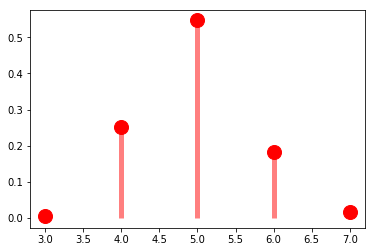

In [214]:
#posterior

fig, ax = plt.subplots(1, 1)
ax.plot(r, p, 'ro', ms=14, label='Prior')
ax.vlines(r, 0, p, colors='r', lw=5, alpha=0.5)

In [200]:
def calc(X, b, r, c, J, mu):
    blop = 0.0
    if c > 0: blop += X[r,c-1]
    if c < 2: blop += X[r,c+1]
    if r > 0: blop += X[r-1,c]
    if r < 2: blop += X[r+1,c]
        
    factor = - J * blop - mu * b[r,c]
    neg = np.exp(- (-1. * factor))
    pos = np.exp(- (+1. * factor))
    return neg / (neg + pos)

In [235]:
def gibbin_it_up(init, X, J, mu, iters, trace):
    for s in range(iters):
        test = np.random.uniform(size=(3, 3))
        for r in range(3):
            for c in range(3):
                p = calc(init, X, r, c, J, mu)
                init[r,c] = -1. if test[r,c] < p else +1.
        trace[s] = init.sum()

In [236]:
#a

init = np.array([[1,1,1],
              [-1,-1,-1],
              [-1,-1,-1]])
X = np.where(np.random.uniform(size=(3,3)) < 1. - 0.5, -1, 1)
iters = 1000000
j = 1
mu = 0

trace = np.zeros(iters)
gibbin_it_up(init, X, j, mu, iters, trace)
trace_a = trace.copy()

In [244]:
for_ci = abs(trace_a)/9
mean = np.mean(for_ci)
print('Probability: ', mean)

Probability:  0.963437333333


In [256]:
q = 100000
batched = np.zeros(10)
for x in range(0,10):
    batched[x] = np.mean(for_ci[x*q:(x+1)*q])
var = sum((batched-mean)**2)/(len(batched)-1)

CI = sp.stats.t.interval(0.90, len(batched)-1, 
                       loc=mean, 
                       scale=np.sqrt(var))

print('90% CI: ', CI)

90% CI:  (0.96259739137821465, 0.96427727528845208)


In [215]:
#b

init = np.array([[1,1,1],
              [-1,-1,-1],
              [-1,-1,-1]])
X = np.where(np.random.uniform(size=(3,3)) < 1. - 0.5, -1, 1)
iters = 1000000
j = 4
mu = 0

trace = np.zeros(iters)
gibbin_it_up(init, X, j, mu, iters, trace)
trace_b = trace.copy()

In [257]:
for_ci = abs(trace_b)/9
mean = np.mean(for_ci)
print('Probability: ', mean)

Probability:  0.999999555556


In [258]:
q = 100000
batched = np.zeros(10)
for x in range(0,10):
    batched[x] = np.mean(for_ci[x*q:(x+1)*q])
var = sum((batched-mean)**2)/(len(batched)-1)

CI = sp.stats.t.interval(0.90, len(batched)-1, 
                       loc=mean, 
                       scale=np.sqrt(var))

print('90% CI: ', CI)

90% CI:  (0.99999697919463315, 1.000002131916478)


(a)

We can represent the random walk on the cayley tree as a markov chain by specifying the transition probabilities as such:


$
P_{uv} = p_{ij}= 
\begin{cases}
    \frac{1}{k},& \text{if } i \neq j\\
    0,              & \text{if } i=j
\end{cases}
$

This makes sense for both nodes and leaves on the tree. 

If you're at a node, you can move on any of the other edges to the next node or leaf with uniform distribution $P_{uv}=p_{ij}=\frac{1}{k}$ with $k$ representing the adjacent edges, but you can't move to to yourself, hence the $p_{ii}=0$

If you're at a leaf, again, you can't move to yourself, so you have to move backwards with $P_{uv}=p_{ij}=\frac{1}{k}=1$

(b)

The markov chain is irreducible. You can get to any of the states through the other states without getting stuck in a state or class of states.

(c)

The markov chain is aperiodic. There is no guaranteed return to a certain state over a given time period.

(d)

Over a random walk on graph G = (E edges,V vertices) we can show that the equilibrium $\pi_u = \frac{k_u}{2E}$ such that: 

$\pi P = \pi$

whereas

$\pi P = \sum_u = P_{uv}\pi_u$

$= \sum_{u:(u,v)\in E} \frac{k_u}{2E}\frac{1}{k_u}$

$= \sum_{u:(u,v)\in E} \frac{1}{2E} = \pi_u$

verify with transition matrix

(a)

In [373]:
observed = [7,7,7,7,7,6,4,7,5,5,5,5,7,6,6,7]

In [374]:
def lik(p):
    return ((p+(1.0-p)**5)**4)*p*(1.0-p)*p*((1.0-p)**2)*\
    ((1.0-p)**2)*p*((1.0-p)**2)*(p**3)*((1.0-p)**3)*p*(1.0-p)*p*((1.0-p)**4)

In [375]:
def log_lik(p):
    return -1*sp.log(lik(p))

In [376]:
res = minimize(log_lik, 0.01, method = 'nelder-mead')
mle = res.x.tolist()[0]

In [377]:
print('MLE: ',mle)

MLE:  0.3630625000000006


In [414]:
def likelihood(p, data):
    def l(p):
        if data[0] == 7:
            l = (p+(1.0-p))**4
        elif data[0] == 6:
            l = (p*(1.0-p))
        elif data[0] == 5:
            l = (p*(1.0-p)**2)
        elif data[0] == 4:
            l = (p*(1.0-p)**3)
        elif data[0] == 3:
            l = (p*(1.0-p)**4)
        else:
            l=1
        for i in range(1,len(data)):
            delta = data[i-1]-data[i]
            if data[i] == 7:
                if delta == 0:
                    l *= (p*(1.0-p))**4
                elif delta == -1:
                    l *= ((1.0-p)**4)
                elif delta == -2:
                    l *= ((1.0-p)**3)
                elif delta == -3:
                    l *= ((1.0-p)**2)
                else:
                    l *= 1.0
            elif data[i] == 6:
                if delta == 1:
                    l *= (p*(1.0-p))
                elif delta == 0:
                    l *= p
                else:
                    l *= 1.0
            elif data[i] == 5:
                if delta == 1:
                    l *= (p*(1.0-p))
                elif delta == 2:
                    l *= (p*(1.0-p)**2)
                elif delta == 0:
                    l *= p
                else:
                    l *= 1.0
            elif data[i] == 4:
                if delta == 1:
                    l *= (p*(1.0-p))
                elif delta == 2:
                    l *= (p*(1.0-p)**2)
                elif delta == 3:
                    l *= (p*(1.0-p)**3)
                elif delta == 0:
                    l *= p
                else:
                    l *= 1.0
            elif data[i] == 3:
                if delta == 1:
                    l *= (p*(1.0-p))
                elif delta == 2:
                    l *= (p*(1.0-p)**2)
                elif delta == 3:
                    l *= (p*(1.0-p)**3)
                elif delta == 4:
                    l *= (p*(1.0-p)**4)
                elif delta == 0:
                    l *= p
                else:
                    l *= 1.0
            else:
                l *= 1
        return l
    return l(p)

(b)

as we increase the amount of samples, we can see that the band on the confidence intervals for our estimator gets tighter and tighter

In [486]:
def booter(b):
    j = 5
    r = geom.rvs(0.3630625, size=b*j).tolist()
    for y in range(len(r)):
        if r[y] <= 2 or r[y] > 7: 
            r[y] = 7
    trace = np.zeros(int(len(r)/5))
    for i in range(int(len(r)/5)):
        k = r[j*i:j*i+5]
        def b(p): return -1*sp.log(likelihood(p, k))
        res = minimize(b, 0.01, method='nelder-mead')
        trace[i] = res.x.tolist()[0]
    return trace

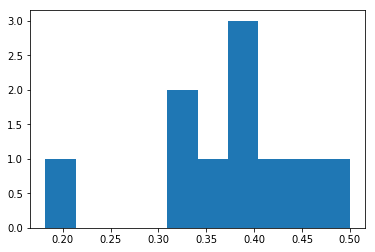

90% CI:  (0.31849745923035844, 0.41989004076964265)


In [503]:
b = 10
res = booter(b)
res = res.tolist()
plt.hist(res)        
plt.show()
CI = sp.stats.t.interval(0.90, len(res)-1, 
                       loc=np.mean(res), 
                       scale=sp.stats.sem(res))

print('90% CI: ', CI)

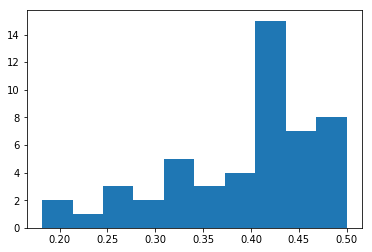

90% CI:  (0.37512035002364941, 0.41366464997635177)


In [504]:
b = 50
res = booter(b)
res = res.tolist()
plt.hist(res)        
plt.show()
CI = sp.stats.t.interval(0.90, len(res)-1, 
                       loc=np.mean(res), 
                       scale=sp.stats.sem(res))

print('90% CI: ', CI)

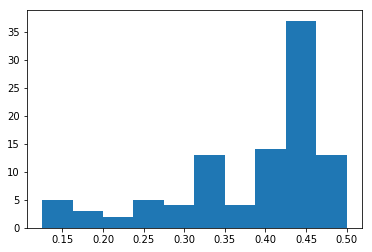

90% CI:  (0.36469073681811909, 0.39627176318188201)


In [505]:
b = 100
res = booter(b)
res = res.tolist()
plt.hist(res)        
plt.show()
CI = sp.stats.t.interval(0.90, len(res)-1, 
                       loc=np.mean(res), 
                       scale=sp.stats.sem(res))

print('90% CI: ', CI)

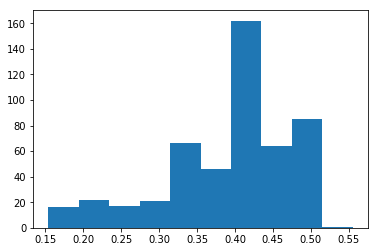

90% CI:  (0.38788532432502887, 0.40047567567497233)


In [506]:
b = 500
res = booter(b)
res = res.tolist()
plt.hist(res)        
plt.show()
CI = sp.stats.t.interval(0.90, len(res)-1, 
                       loc=np.mean(res), 
                       scale=sp.stats.sem(res))

print('90% CI: ', CI)

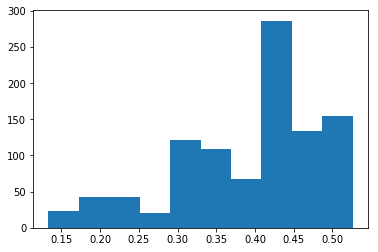

90% CI:  (0.38280644656816126, 0.39214467843183992)


In [507]:
b = 1000
res = booter(b)
res = res.tolist()
plt.hist(res)        
plt.show()
CI = sp.stats.t.interval(0.90, len(res)-1, 
                       loc=np.mean(res), 
                       scale=sp.stats.sem(res))

print('90% CI: ', CI)

(c)

One way to think about this (and compare simulation results), would be to look at the expectation given by $\frac{1-p^*}{p^*}$

In [501]:
(1-mle)/mle

1.7543467033912847

In [494]:
def new_booter(b):
    j = 5
    r = geom.rvs(0.3630625, size=b*j).tolist()
    trace = np.zeros(int(len(r)/5))
    for i in range(int(len(r)/5)):
        k = r[j*i:j*i+5]
        likelihood(p, k)
        trace[i] = np.mean(k)
    return trace

In [498]:
res = new_booter(100)

CI = sp.stats.t.interval(0.90, len(res)-1, 
                       loc=np.mean(res), 
                       scale=sp.stats.sem(res))

print('90% CI: ', CI)

90% CI:  (2.7265609879059305, 3.0614390120940689)


Mean:  2.894


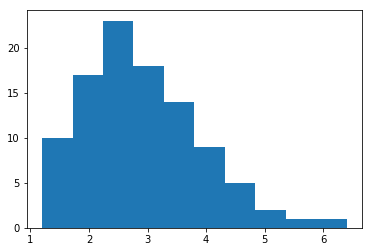

In [500]:
print('Mean: ',np.mean(res))
plt.hist(res)        
plt.show()